# Notes on CRS

quick note on to_crs:<br>
'geometry' is in a geographic CRS (probably epsg= 44326) which uses lat,lon in degrees<br>
when calculating centroid on data in degrees the math trests egrees as if they're equal distances. But they aren not!<br>
- 1 degree of longitude at the equator ≈ 111 km<br>
- 1 degree of longitude in Denmark ≈ 70 km<br>
- This makes centroids slightly wrong!<br>
<br>
What does to_crs(epsg=25833) do?<br>
EPSG:25833 is ETRS89 / UTM zone 33N - a projected coordinate system for Denmark that:<br>

- Uses meters instead of degrees<br>
- Projects the curved Earth onto a flat map<br>
- Makes distances and calculations accurate for Denmark<br>

In [7]:
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy import stats

In [8]:
#variables 
epsg_dk = 25832

# 0. Checking out the datasets:

- Check isna vesaire

In [9]:
org_stations = gpd.read_file('data/raw/original_stations.geojson')
org_stations = org_stations.to_crs(epsg_dk)
org_stations = org_stations.drop_duplicates(subset=['name'])

#lots of unnecessary columns, let's get rid of them
stations = org_stations[['name', 'geometry']].copy()

area = gpd.read_file('data/raw/storkøbenhavn.geojson')
area = area.to_crs(epsg=epsg_dk)

In [10]:
print(f'we have with {len(stations)} stations to work with.')

we have with 129 stations to work with.


# Visualisation of initial data

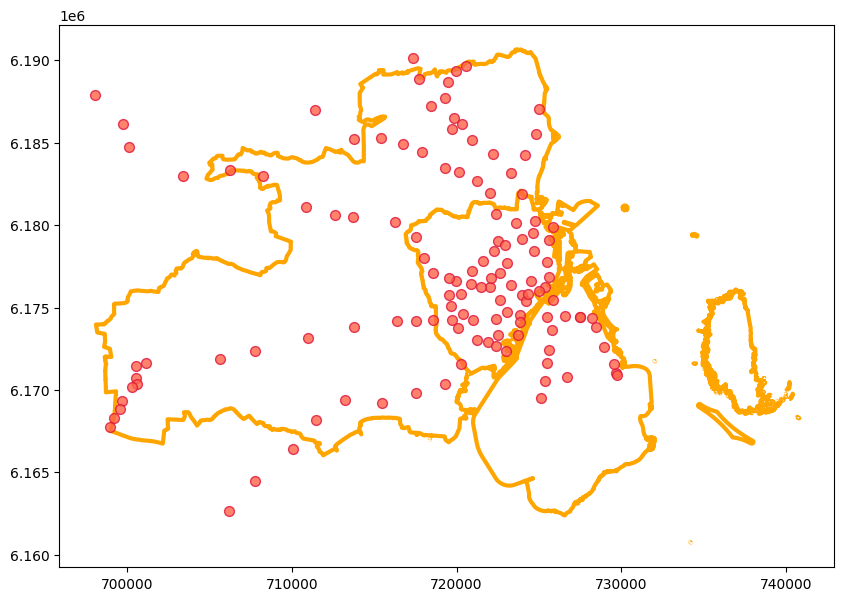

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
area.plot(ax=ax,color='white', edgecolor='orange', linewidth=3)
stations.plot(ax=ax,marker='.', color='tomato', edgecolor='crimson', markersize=200, alpha =0.8)
plt.show()

OSM weirdness is not unexpected, we have a couple of staitons outside of the region...<br>
Let's clean that up before we move on. Also on the edges

In [12]:
st_to_delete = ['Lyngby Lokal', 'Værløse', 'Holte', 'Hareskov', 'Veksø','Stenløse', 'Egedal', 'Ølstykke', 'Hundige', 'Greve', 'Karlslunde', 'Hedehusene', 'Hedehusgård', 'Sølund', 'Stenager Trinbræt', 'Brandhøj', 'Flintebjerg Trinbræt', 'Fem Ege', 'Rubjerg', 'Hedenlands Veteranbane', 'Plantagen Trinbræt', 'Lufthavnen (Metro)', 'Tårnby']
stations = stations[~stations['name'].isin(st_to_delete)]
print(f'Deleted {len(st_to_delete)} stations. This gives us {len(stations)} stations to work with.')

Deleted 23 stations. This gives us 107 stations to work with.


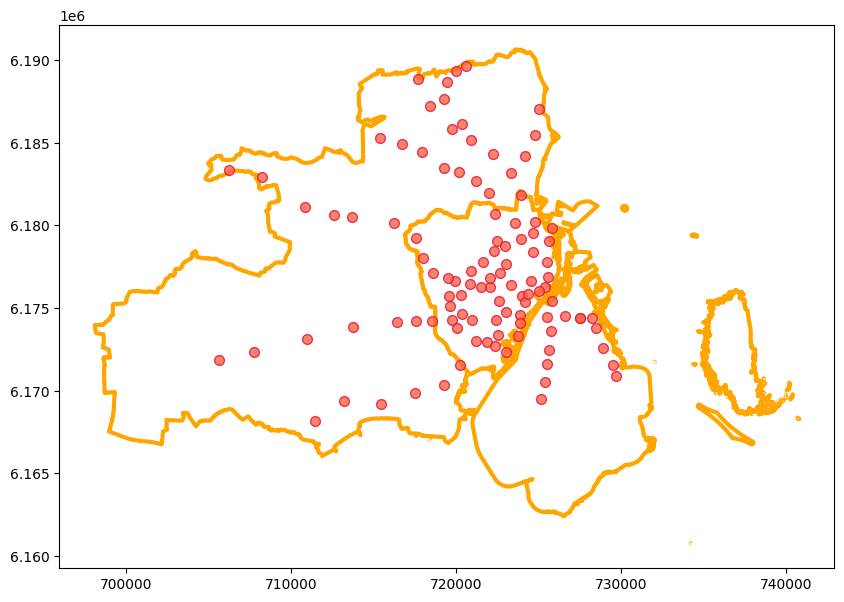

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
area.plot(ax=ax,color='white', edgecolor='orange', linewidth=3)
stations.plot(ax=ax,marker='.', color='tomato', edgecolor='crimson', markersize=200, alpha =0.8)
plt.show()

In [14]:
stations.to_file('data/processed/stations.geojson', driver='GeoJSON')

# 1. Scraping google reviews

In [15]:
# Google api used in another file. I have a geojson and geopackage from qgis with places tagged with
#cuisine = kebab.

org_kebap_places = gpd.read_file('data/raw/original_kebap_places.geojson')
org_kebap_places.columns

Index(['full_id', 'osm_id', 'osm_type', 'cuisine', 'caterer', 'craft', 'email',
       'diet:meat', 'diet:halal', 'brand', 'brand:website', 'branch',
       'contact:email', 'drive_through', 'delivery', 'toilets', 'smoking',
       'payment:mobilepay', 'air_conditioning', 'payment:debit_cards',
       'payment:credit_cards', 'indoor_seating', 'check_date',
       'diet:vegetarian', 'diet:vegan', 'toilets:wheelchair',
       'outdoor_seating', 'fvst:fixme', 'takeaway', 'alt_name',
       'opening_hours:signed', 'check_date:opening_hours', 'wheelchair',
       'website', 'ref:DK:cvr:pnummer', 'ref:DK:cvr', 'phone', 'opening_hours',
       'name', 'fvst:navnelbnr', 'fvst:name', 'amenity', 'geometry'],
      dtype='object')

In [16]:
#as there are 10s of columns we dont really need, all we really need is the name and  geomtery columns.
kebap_places = org_kebap_places[['name', 'geometry']].copy()

In [17]:
#while we are at it we'll project ont othe same epsg.
kebap_places = kebap_places.to_crs(epsg=epsg_dk)
print(f'we have with {len(kebap_places)} kebap places.')
#Which seems pretty accurate as there are plenty of kebap places around Storkøbenhavn.

we have with 117 kebap places.


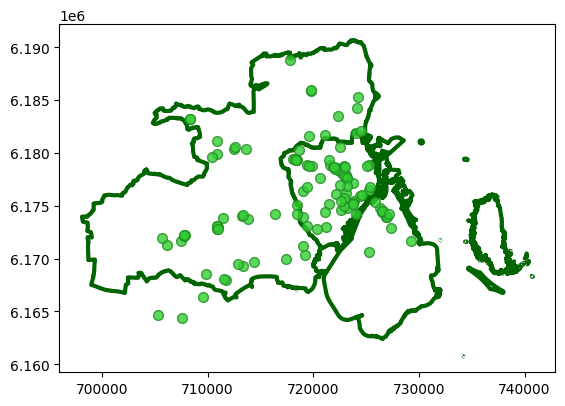

In [18]:
fig, ax = plt.subplots()

area.plot(ax=ax,color='white', edgecolor='darkgreen', linewidth=3)
kebap_places.plot(ax=ax,marker='.', color='limegreen', edgecolor='forestgreen', markersize=200, alpha =0.8)
plt.show()

We again have some places outside of the area so we'll clean that up as well, before calling the google api and using all of our free credits.

Before deleting the specific kebap places I'll check if they are part of a branch. Which one of them seems to be, so we'll handle that case seperatly.

In [19]:
duplicates = kebap_places['name'].value_counts()
print(duplicates[duplicates > 1])

name
Killer Kebab    4
Konya Kebab     3
Kebabi          2
Kebabland       2
City Kebab      2
Name: count, dtype: int64


In [20]:
kebap_places[kebap_places['name'] == 'Konya Kebab']

,name,geometry
9,Konya Kebab,POINT (723148.674 6177659.672)
17,Konya Kebab,POINT (707776.283 6172090.852)
24,Konya Kebab,POINT (709576.53 6166343.062)


In [21]:
places_to_delete= ["Roll N’ Eat", "Kebabi", "Virum Kebab house"]
kebap_places = kebap_places[~kebap_places['name'].isin(places_to_delete)]

kebap_places = kebap_places.drop(index=24)

print(f'We got {len(kebap_places)} kebap places left.')

We got 112 kebap places left.


Now we can get the ratings from each kebap place, with the help of Google API. <br>
Let's hope we have enough credits left.

In [22]:
kebap_places.to_file('data/processed/kebap_places.geojson', driver='GeoJSON')

You know what we'll just manually add the missing stations. Since I'm familiar with the public transportation it shouldn't be that much of a trouble

In [23]:
google_ratings = pd.read_csv('data/results/kebap_with_ratings.csv')
google_ratings.dtypes

osm_name         object
rating          float64
review_count    float64
dtype: object

In [24]:
google_ratings['review_count'] = google_ratings['review_count'].astype('Int32')

In [25]:
google_ratings.head()

,osm_name,rating,review_count
0,Kebabish,3.8,2492
1,Yilmaz Döner Kebab,3.9,112
2,Kebab Time,4.2,188
3,King of Kebab,3.9,648
4,Torvets Shawarma Kebab,3.5,113


In [26]:
kebap_w_ratings = kebap_places.merge(
     google_ratings,
     left_on='name',
     right_on='osm_name',
     how='left'
)
type(kebap_w_ratings)

geopandas.geodataframe.GeoDataFrame

In [27]:
kebap_w_ratings.drop('osm_name', axis=1, inplace=True)
kebap_w_ratings.head()

,name,geometry,rating,review_count
0,Kebabish,POINT (723873.666 6175448.109),3.8,2492
1,Yilmaz Döner Kebab,POINT (721582.174 6178839.267),3.9,112
2,Kebab Time,POINT (707530.063 6171669.679),4.2,188
3,King of Kebab,POINT (723777.467 6177119.905),3.9,648
4,Torvets Shawarma Kebab,POINT (718439.136 6175072.993),3.5,113


# 2. Distance Metric: Euclidean.
Walking distance from a kebap place to the nearest train station would be preferable. But that is computanionally expensive for this big of an area, and such silly project.
Additionally, in Copenhagen's dense urban environment the Euclidean distance will highly likely provide similar numbers. While the walking distance would be more precised in absolute values, the ranking of which station is closeset remains consistent across metrics. Since the analysis focuses on relative proximity rather than absolute distances, Euclidean distance stays approptiate and computationally efficient.

Pick 5-10 kebab places
Calculate both Euclidean and walking distance to their 3 nearest stations
Show that the ranking stays the same
"A sample validation (n=10) confirmed that the nearest station by Euclidean distance matched the nearest station by network distance in 100% of cases"

Notes on the function:<br>
- Store the distances dictionary inside the kebap loop. Because we want to calculate distances from ONE kebap place to ALL stations. So it's better to renew the dictionary for each kebap place. So at the end we don't store all distances possbile. Which would be a lot of data. But only the minimum for the result.
- Calculate minimum dist, and station name inside the kebap loop. Because after each iteration(for each kebap place) we want the closest station before moving on to the next one.

In [28]:
def closest_station(places, stations):

     result = []
     
     #iterate over each kebap place
     for idx_k, row_k in places.iterrows():
          distances = {} #store the distances
          
          #get coordinates of each kebap place
          loc_k= row_k.geometry.x, row_k.geometry.y

          #calculate distances from the kebap place to each station
          for idx_s, row_s in stations.iterrows():
               loc_s= row_s.geometry.x, row_s.geometry.y
               distance = euclidean(loc_k, loc_s)
               distances[row_s['name']] = distance
          min_dist = min(distances.values())
          closest_st = min(distances, key=distances.get)
     
          result.append({
          'kebap_place_name': row_k['name'],
          'closest_station': closest_st,
          'distance': min_dist
          })
     
     result_df = pd.DataFrame(result)

     return result_df

In [29]:
closest_stations = closest_station(kebap_places, stations)

In [30]:
closest_stations.to_csv('data/results/closest_stations.csv')

In [31]:
df = closest_stations.merge(kebap_w_ratings, left_on='kebap_place_name', right_on = 'name')
df.head()

,kebap_place_name,closest_station,distance,name,geometry,rating,review_count
0,Kebabish,Københavns Hovedbanegård,320.735858,Kebabish,POINT (723873.666 6175448.109),3.8,2492
1,Yilmaz Döner Kebab,Nørrebro,817.951151,Yilmaz Döner Kebab,POINT (721582.174 6178839.267),3.9,112
2,Kebab Time,Taastrup,712.170092,Kebab Time,POINT (707530.063 6171669.679),4.2,188
3,King of Kebab,Forum,858.489969,King of Kebab,POINT (723777.467 6177119.905),3.9,648
4,Torvets Shawarma Kebab,Hvidovre,865.739767,Torvets Shawarma Kebab,POINT (718439.136 6175072.993),3.5,113


In [32]:
df.drop(columns='name', inplace=True)

print(df.isna().sum())
df = df.dropna(subset=['rating', 'distance'])

kebap_place_name    0
closest_station     0
distance            0
geometry            0
rating              1
review_count        1
dtype: int64


In [33]:
df.head()

,kebap_place_name,closest_station,distance,geometry,rating,review_count
0,Kebabish,Københavns Hovedbanegård,320.735858,POINT (723873.666 6175448.109),3.8,2492
1,Yilmaz Döner Kebab,Nørrebro,817.951151,POINT (721582.174 6178839.267),3.9,112
2,Kebab Time,Taastrup,712.170092,POINT (707530.063 6171669.679),4.2,188
3,King of Kebab,Forum,858.489969,POINT (723777.467 6177119.905),3.9,648
4,Torvets Shawarma Kebab,Hvidovre,865.739767,POINT (718439.136 6175072.993),3.5,113


# 3. Plot time!

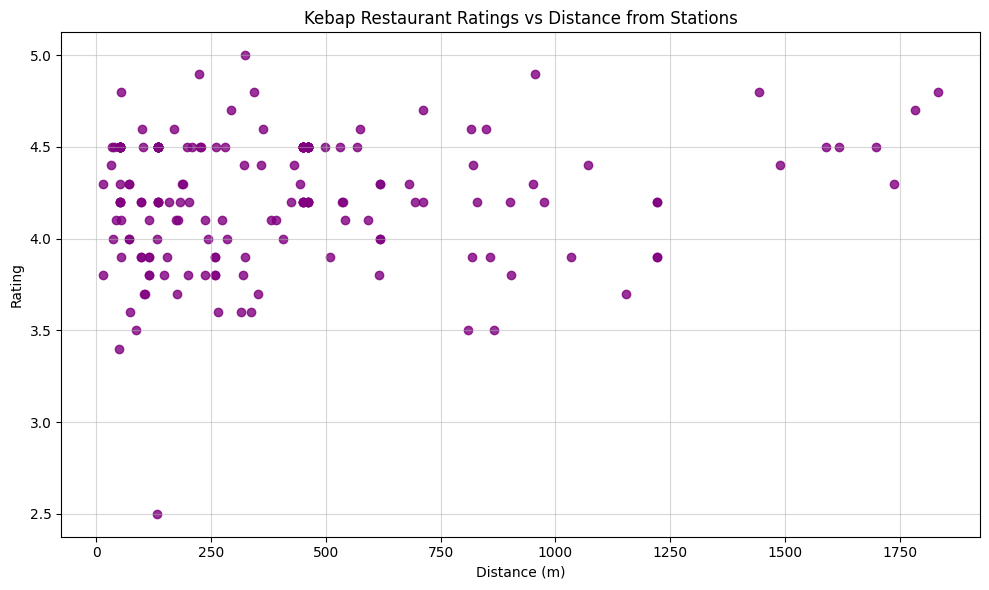

In [44]:
#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['distance'], df['rating'], color='purple', alpha= 0.8)
plt.xlabel('Distance (m)')
plt.ylabel('Rating')
plt.title('Kebap Restaurant Ratings vs Distance from Stations')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
cor_s, p_val_s = stats.spearmanr(df['rating'], df['distance'])
cor_s, p_val_s

(0.07991481045553137, 0.27434643416644583)

In [36]:
cor_p, p_val_p = stats.pearsonr(df['rating'], df['distance'])
cor_p, p_val_p

(0.11874796879927818, 0.1036419573277294)

# 4. Conclusion

Well I didn't expect any scientific reasoning to the rating-distance (non-existing) relationship. <br>
- There is essentially no meaningful correlation between the two, as the spearman correlation is very close to 0.
- The p value > 0.05 means we fail to reject the null hypothesis that there is no linear relationship between them. Which is backed up by the pearson correlation results.
- The weak (non zero)correlation could easily be due to random chance and it is NOT statistically significant.
- Neither of the two correaltion metrics reached the statistical significance at 0.05 level. Results suggest a 'possible' weak effect that may require larger sample size to detect.
- The hypothesis has failed once again. 
- I have to mention that Copenhagen being a dense city with metro/railways stations everywhere is not helpfull in this case as most of the kebap place will be close to some station in the end. We can see this in the scatterplot that the closest station to any kebap place is under 2km away. (For the greater Copenhagen area ofc)